In [10]:
# ! pip install streamlit
! pip install plotly

  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
Using cached plotly-5.24.1-py3-none-any.whl (19.1 MB)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
from datetime import timedelta
import plotly.express as px
import sqlite3

pd.set_option('display.max_columns', 40)
# display max rows 75
pd.set_option('display.max_rows', 75)

Utiliser les tables parquets déjà dans le dossier data_sources_pyhon et pas la connection à sqlite3

In [ ]:

# # check des tables
# # Chemin vers SQLite, depuis le répertoire "update"
# database_path = "../sqlite/update/statistics.sqlite3"


# # Connexion à la base de données SQLite
# conn = sqlite3.connect(database_path)

# # Liste toutes les tables de la base de données
# query = "SELECT name FROM sqlite_master WHERE type='table';"
# tables = pd.read_sql(query, conn)

# # Charger une table de la base de données dans un df pandas
# book = 'book'
# df_book_new = pd.read_sql(f"SELECT * FROM {book};", conn)
# sqlite_sequence = 'sqlite_sequence'
# sqlite_sequence_table = pd.read_sql(f"SELECT * FROM {sqlite_sequence};", conn)
# numbers = 'numbers'
# numbers_table = pd.read_sql(f"SELECT * FROM {numbers};", conn)
# page_stat_data = "page_stat_data"
# df_page_stat_data = pd.read_sql(f"SELECT * FROM {page_stat_data};", conn)
# # print le nombre de ligne de df_book_new
# print("Nombre de lignes de df_book_new : ", df_book_new.shape[0])
# # print le nombre de ligne de df_page_stat_data
# print("Nombre de lignes de df_page_stat_data : ", df_page_stat_data.shape[0])

# # fermer de la connexion à la base de données
# conn.close()

Nombre de lignes de df_book_new :  60
Nombre de lignes de df_page_stat_data :  20085


In [ ]:
# print(tables)

              name
0             book
1  sqlite_sequence
2   page_stat_data
3          numbers


Pour reprendre en route, possible de récupérer directement la verion du dataset depuis les fichiers parquets

In [3]:
# df_book = pd.read_parquet('df_book.parquet')
df_book_updated = pd.read_parquet('../data_sources_from_python/df_book_updated.parquet')
# df_book_streamlit = pd.read_parquet("df_book_streamlit.parquet")
df_stat = pd.read_parquet('../data_sources_from_python/stats_lecture.parquet')


In [4]:
df_stat.sort_values(by='heure de début', ascending=False).head(5)

,id_book,page,heure de début,Temps passé sur la page en seconde,total_pages,id_long,Temps de lecture en minute,Temps de lecture en heure,date lecture,Heure de début de lecture,Heure,Heure en décimal,Jour Précédent,Est Consécutif,date de fin de lecture
20387,79,21,2024-12-01 11:44:20,74,515,00079,1.233333,0.020556,2024-12-01,11:44:20,11,11.733333,2024-11-30,False,2024-12-01
20386,79,20,2024-11-29 21:54:04,26,515,00079,0.433333,0.007222,2024-11-29,21:54:04,21,21.900000,2024-11-28,True,2024-12-01
20385,79,19,2024-11-29 21:53:57,7,515,00079,0.116667,0.001944,2024-11-29,21:53:57,21,21.883333,2024-11-28,True,2024-12-01
20384,79,18,2024-11-29 21:53:16,41,515,00079,0.683333,0.011389,2024-11-29,21:53:16,21,21.883333,2024-11-28,True,2024-12-01
20383,79,17,2024-11-29 21:52:45,31,515,00079,0.516667,0.008611,2024-11-29,21:52:45,21,21.866667,2024-11-28,True,2024-12-01


# visuel 1 : table avec la liste des livres lus dans l'année. --> DONE
## step 1 : easy
* trié du plus récent au plus ancien 
* uniquement les livres lus en entier

## step 2 : 
* Récupérer le nombre de jour de lecture pour chaque livre 
* calculer le nombre de pages lues par jour de lecture
* calculer le nombre d'heures de lecture par jour de lecture
* calculer la vitesse de lecture : page /min

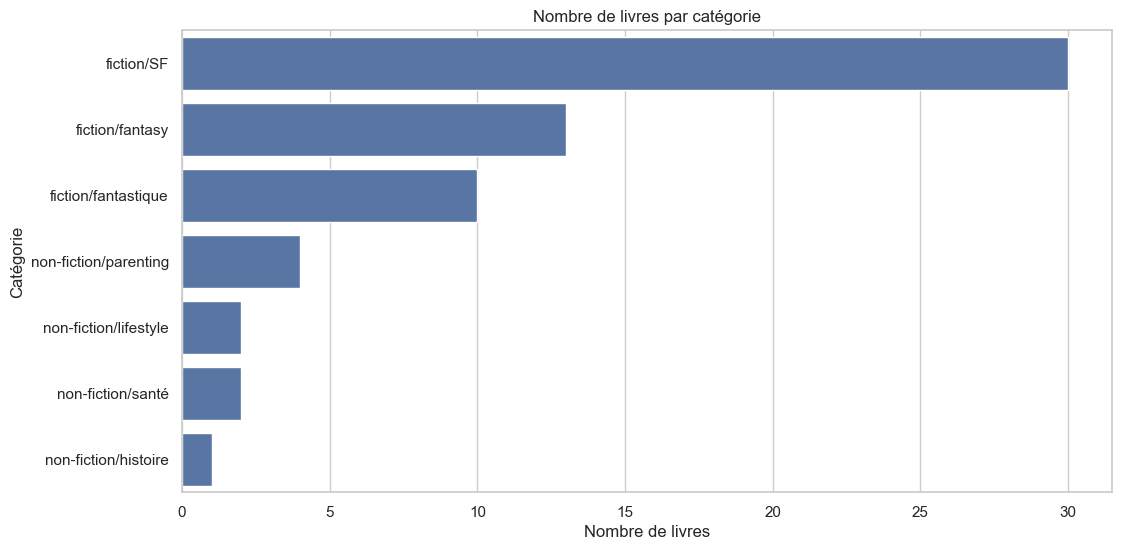

In [6]:
# plot avec seaborn en bar chhat le nombre de livre par categorie

#TODO 1 couleur par categorie principale "fiction" ou "non-fiction"


sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.countplot(y='Catégorie', data=df_book_updated, order=df_book_updated['Catégorie'].value_counts().index)
plt.title('Nombre de livres par catégorie')
plt.xlabel('Nombre de livres')
plt.ylabel('Catégorie')
plt.show()

In [7]:
# Calculer le nombre de livres par catégorie
category_counts = df_book_updated['Catégorie'].value_counts().reset_index()
category_counts.columns = ['Catégorie', 'nombre de livre']
category_counts_sorted = category_counts.sort_values(by='nombre de livre', ascending=True)

# Créer un graphique à barres horizontal
fig = px.bar(category_counts_sorted,
             x='nombre de livre', 
             y='Catégorie',
             orientation='h',  # 'h' indique un bar chart horizontal
             title='Nombre de livres par catégorie',
             labels={'nombre de livre': 'Nombre de livres', 'Catégorie': 'Catégories'})

# Afficher le graphique
fig.show()

# visuel 2
heatmap heure de lecture et calendrier
https://plotly.com/python/heatmaps/
A retravailler mais on est pas loin


sinon : 
https://python.plainenglish.io/interactive-calendar-heatmaps-with-plotly-the-easieast-way-youll-find-5fc322125db7
Mais ça rend moche

In [ ]:
# ! pip install plotly_calplot 

  Attempting uninstall: pytz
    Found existing installation: pytz 2024.2
    Uninstalling pytz-2024.2:
      Successfully uninstalled pytz-2024.2



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
from plotly_calplot import calplot


# prendre uniquement les données de 2024 date de lecture
df_stat2 = df_stat[df_stat['heure de début'].dt.year == 2024]


fig = calplot(df_stat2, x="date lecture", y="Temps de lecture en minute")
fig.show()

d:\6.dev\book_data_analysis\.venv\Lib\site-packages\plotly_calplot\calplot.py:159: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
! pip install calmap


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\chric\AppData\Local\Temp\ipykernel_14868\1789621246.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



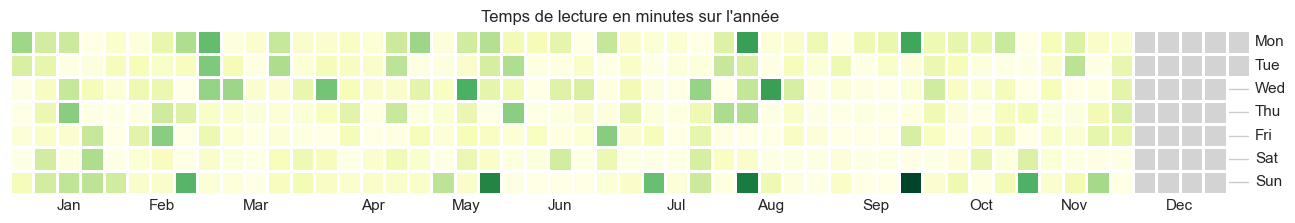

In [ ]:
import calmap
import matplotlib.pyplot as plt
# passer df_stat2['date lecture'] en dt time
df_stat2['date lecture'] = pd.to_datetime(df_stat2['date lecture'])
df_aggregated = df_stat2.groupby('date lecture')['Temps de lecture en minute'].sum().reset_index()
df_serie = df_aggregated.set_index('date lecture')['Temps de lecture en minute']

# Remplir les dates manquantes avec 0
df_serie = df_serie.asfreq('D', fill_value=0)



plt.figure(figsize=(16, 10))
calmap.yearplot(
    df_serie,
    year=df_serie.index.year[0],
    fillcolor='lightgrey',
    cmap='YlGn',
    linewidth=2,
    dayticks = True
    )

plt.title('Temps de lecture en minutes sur l\'année')
plt.show()


# 3 score card
* plus longue lecture : heure de lecture max
* le plus régulier : jour de lecture = intervalle de lecture
* plus rapide : page lues à la minute
* plus addictif : pages lues par jour

## plus longue lecture

In [9]:
# le temps de lecture max
temps_maxi = df_book_streamlit[df_book_streamlit["temps passé sur le livre en heure"] == df_book_streamlit["temps passé sur le livre en heure"].max()]

# prisme livre
titre_max_temps_lecture = df_book_streamlit[df_book_streamlit["temps passé sur le livre en heure"] == df_book_streamlit["temps passé sur le livre en heure"].max()]["Titre"].values[0]
auteur_max_temps_lecture = df_book_streamlit[df_book_streamlit["temps passé sur le livre en heure"] == df_book_streamlit["temps passé sur le livre en heure"].max()]["Auteurs"].values[0]
temps_max_lecture = df_book_streamlit["temps passé sur le livre en heure"].max()


print(f"Livre le plus long à lire : {titre_max_temps_lecture} de {auteur_max_temps_lecture} : {temps_max_lecture}")


Livre le plus long à lire : La Chute d'Hypérion: Le cycle d'Hypérion - Tome 2 de Dan Simmons : 13.3


## plus régulier
Trop de livre dans cette liste

In [50]:
# Afficher les livres ou la durée de lecture est égale à la durée de lecture effective
# df_book_streamlit[df_book_streamlit["jours de lecture effectifs (jl)"] == df_book_streamlit["Durée lecture (j)"]][["Titre", "Durée lecture (j)", "jours de lecture effectifs (jl)"]]

# Compter le nombre de lignes où "jours de lecture effectifs (jl)" est égal à "Durée lecture (j)"
count = df_book_streamlit[df_book_streamlit["jours de lecture effectifs (jl)"] == df_book_streamlit["Durée lecture (j)"]].shape[0]

# affiche le dernier, puis l'avant dernier, puis l'avant avant dernier
df_book_streamlit[df_book_streamlit["jours de lecture effectifs (jl)"] == df_book_streamlit["Durée lecture (j)"]].sort_values(by="Date de lecture", ascending
=False).head(3)[["Titre", "Durée lecture (j)", "jours de lecture effectifs (jl)", "Date de lecture"]]
# enregistre les 3 titres dans une liste
liste_livres = df_book_streamlit[df_book_streamlit["jours de lecture effectifs (jl)"] == df_book_streamlit["Durée lecture (j)"]].sort_values(by="Date de lecture", ascending   =False).head(3)["Titre"].values


print(f"{count} livres lus tous les jours, les 3 derniers : {liste_livres}")


27 livres lus tous les jours, les 3 derniers : ["Projet secret T2 : Manuel de Survie du Sorcier Frugal dans l'Angleterre médiévale"
 'Voyageur 2 : Libration'
 "Blackwater 1 - La crue: L'épique saga de la famille Caskey"]


## le plus rapide
Utiliser le df non filtré

In [55]:
livre_rapide = df_book_updated[df_book_updated["temps passé sur le livre en minute"] > 35]
livre_rapide = livre_rapide[livre_rapide["pages lues à la minute"] == livre_rapide["pages lues à la minute"].max()]

titre_livre_rapide = livre_rapide[livre_rapide["pages lues à la minute"] == livre_rapide["pages lues à la minute"].max()]["Titre"].values[0]
auteur_livre_rapide =livre_rapide[livre_rapide["pages lues à la minute"] == livre_rapide["pages lues à la minute"].max()]["Auteurs"].values[0]
vitesse_livre_rapide =livre_rapide[livre_rapide["pages lues à la minute"] == livre_rapide["pages lues à la minute"].max()]["pages lues à la minute"].values[0].round(1)


# titre_max_temps_lecture = df_book_streamlit[df_book_streamlit["Temps de lecture total (hh:mm:ss)"] == df_book_streamlit["Temps de lecture total (hh:mm:ss)"].max()]["Titre"].values[0]
# auteur_max_temps_lecture = df_book_streamlit[df_book_streamlit["Temps de lecture total (hh:mm:ss)"] == df_book_streamlit["Temps de lecture total (hh:mm:ss)"].max()]["Auteurs"].values[0]
# temps_max_lecture = df_book_streamlit["Temps de lecture total (hh:mm:ss)"].max()



print(f"Livre lu avec la vitessse max : {titre_livre_rapide} de {auteur_livre_rapide} à {vitesse_livre_rapide} pages à la minute")



Livre lu avec la vitessse max : la route de Cormac McCarthy à 2.0 pages à la minute


## plus addictif : max moyenne pages lues par jour

In [56]:
livre_addict = df_book_updated[df_book_updated["minutes_lecture_par_jour_de_lecture"] == df_book_updated["minutes_lecture_par_jour_de_lecture"].max()]
titre_livre_addict = livre_addict["Titre"].values[0]
auteur_livre_addict = livre_addict["Auteurs"].values[0]
minutes_livre_addict = livre_addict["minutes_lecture_par_jour_de_lecture"].values[0]

print(f"Livre lu avec la moyenne de temps de lecture par jour la plus élevée : {titre_livre_addict} de {auteur_livre_addict} avec {minutes_livre_addict} minutes de lecture par jour")

Livre lu avec la moyenne de temps de lecture par jour la plus élevée : la route de Cormac McCarthy avec 93.7 minutes de lecture par jour


## les stats depuis le prisme inversé : pic de vitesse (date et livre), page lu en 1 journée (date et livre), heure de lecture max en 1 journée (date et livre)

### 1. Heure de lecture max dans la journée

Solution : 

Faire un group by, date lecture : 
* sum : temps passé sur la page
* sum id_book
* concatenate la liste des id_book de chaque ligne ? (ou les titres de livre directement)


--> Permet d'identifier le jour avec le plus longtemps en lecture, et les livres identifiés

In [110]:
# Convertir la colonne 'date lecture' en datetime
df_stat['date lecture'] = pd.to_datetime(df_stat['date lecture'], format='%Y-%m-%d')

# Joindre df_stat avec df_book_updated pour inclure le nom des livres
df_stat2 = df_stat.merge(df_book_updated, left_on='id_book', right_on='id', how='left')

# Agréger les données par 'date lecture'
agg_data = df_stat2.groupby('date lecture').agg({
    'Temps de lecture en minute': 'sum',
    'page': 'nunique',
    'id_book': 'nunique'
}).reset_index()

# Ajouter la liste des id_book et des titres pour chaque date de lecture
book_ids_titles_by_date = df_stat2.groupby('date lecture').apply(
    lambda x: ', '.join(sorted(set(f"{row['id_book']} ({row['Titre']})" for _, row in x.iterrows())))
).reset_index()

# Fusionner les deux DataFrames
merged_data = pd.merge(agg_data, book_ids_titles_by_date, on='date lecture')

# Renommer pour plus de clarté
merged_data.columns = ['date lecture', 'Temps de lecture en minute', 'Nombre de pages', 'Nombre de livres', 'Books']

# Afficher le résultat
print(merged_data)

    date lecture  Temps de lecture en minute  Nombre de pages  \
0     2012-05-01                   36.900000               52   
1     2023-11-21                   33.833333               40   
2     2023-11-22                   21.166667               36   
3     2023-11-23                   91.300000              160   
4     2023-11-24                    9.500000               11   
..           ...                         ...              ...   
265   2024-11-02                   69.783333               92   
266   2024-11-03                  175.100000              237   
267   2024-11-04                   36.633333               69   
268   2024-11-05                   22.150000               31   
269   2024-11-06                    9.816667               15   

     Nombre de livres                                              Books  
0                   2  57 (Légendes et lattes), 58 (Roman secret 3 - ...  
1                   2          1 (nan), 2 (Le crime de l'Orient-Expre

C:\Users\chric\AppData\Local\Temp\ipykernel_21332\33408628.py:15: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [ ]:
# print les 10 premières lignes, triées par 'Temps de lecture en minute' de manière décroissante
merged_data.sort_values('Temps de lecture en minute', ascending=False).head(3)

NameError: name 'merged_data' is not defined

### Pic de vitesse : 

Pic par heure et livres associés

In [114]:
# Ajouter les colonnes 'id_book' et 'Titre' avec valeurs uniques pour chaque groupe
def concatenate_unique_values(series):
    return ', '.join(sorted(set(map(str, series))))

books_info = df_stat2.groupby(['date lecture', 'Heure']).apply(
    lambda x: pd.Series({
        'id_books': concatenate_unique_values(x['id_book']),
        'Titres': concatenate_unique_values(x['Titre'])
    })
).reset_index()

# Fusionner les deux DataFrames
result = pd.merge(agg_data_pic_vitesse, books_info, on=['date lecture', 'Heure'])

# Renommer les colonnes pour plus de clarté (si nécessaire)
result.columns = ['date lecture', 'Heure', 'Nombre de pages', 'Temps passé sur la page en seconde', 'Temps de lecture en minute', 'id_books', 'Titres']

# Afficher le ré

C:\Users\chric\AppData\Local\Temp\ipykernel_21332\2549705109.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [ ]:
result["page à la minute"] = (result["Nombre de pages"] / (result["Temps de lecture en minute"] )).round(2) 

# faire un head de result trié par page à la minute, uniquement quand page supérieur à 60
result[result["Nombre de pages"] > 60].sort_values(by='page à la minute', ascending=False).head(5)
# result.sort_values(by='page', ascending=False).head(10)

,date lecture,Heure,Nombre de pages,Temps passé sur la page en seconde,Temps de lecture en minute,id_books,Titres,page à la minute
240,2024-02-28,21,79,2123,35.383333,25,Le manuel de survie des parents,2.23
281,2024-03-19,0,100,2736,45.600000,32,la route,2.19
455,2024-05-21,16,73,2046,34.100000,39,Skyward T3 : Cytonique,2.14
451,2024-05-20,19,71,2037,33.950000,39,Skyward T3 : Cytonique,2.09
17,2023-11-23,12,63,1821,30.350000,2,Le crime de l'Orient-Express,2.08
599,2024-07-24,16,79,2336,38.933333,58,Roman secret 3 - Yumi et le peintre de cauchemars,2.03
612,2024-07-28,9,78,2306,38.433333,58,Roman secret 3 - Yumi et le peintre de cauchemars,2.03
608,2024-07-27,21,106,3166,52.766667,58,Roman secret 3 - Yumi et le peintre de cauchemars,2.01
280,2024-03-18,23,117,3593,59.883333,32,la route,1.95
772,2024-09-29,9,110,3407,56.783333,67,Voyageur 1 : L'Espace d'un an,1.94


<Axes: xlabel='Heure', ylabel='count'>

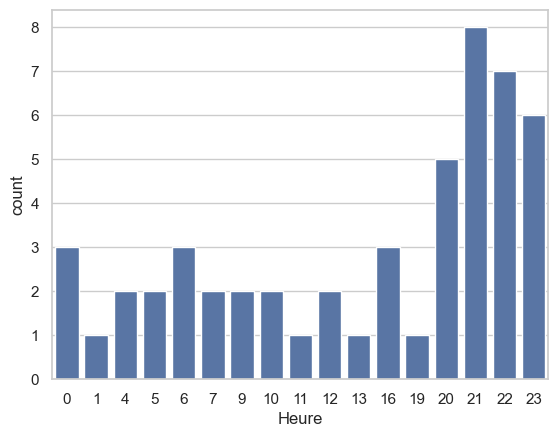

In [119]:
# plot le nombre de fois où chaque heure apparait pour "result[result["Nombre de pages"] > 60].sort_values(by='page à la minute', ascending=False).head(100)"
sns.countplot(x='Heure', data=result[result["Nombre de pages"] > 60].sort_values(by='page à la minute', ascending=False).head(100))

### nombre d'auteurs et nombres de livres lus

In [123]:
# print le nombre de lignes de df_book_updated
nb_livres_lus = df_book_streamlit.shape[0]
# print le nombre d'Auteurs lus de df_book_updated
nb_auteurs_lus = df_book_streamlit["Auteurs"].nunique()


print(f"{nb_livres_lus} livres lus, de {nb_auteurs_lus} auteurs différents")

56 livres lus, de 38 auteurs différents


# MATRICE PYTHON

Exemple : 

In [3]:
# Créer une matrice 3x3 avec des étiquettes (labels)
data = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
]

# Définir les noms des colonnes et des index (lignes)
columns = ['A', 'B', 'C']
index = ['R1', 'R2', 'R3']

# Créer le DataFrame
df = pd.DataFrame(data, columns=columns, index=index)

print(df)

    A  B  C
R1  1  2  3
R2  4  5  6
R3  7  8  9


In [18]:
df_book_updated = pd.read_parquet("../data_sources_from_python/df_book_updated.parquet")
# df_book_streamlit = pd.read_parquet("df_book_streamlit.parquet")
df_stat = pd.read_parquet("../data_sources_from_python/stats_lecture.parquet")
# préparer df_book_updated pour le filtre : 
df_book_updated['Date de lecture'] = pd.to_datetime(df_book_updated['Date de lecture'], format="%Y-%m-%dT%H:%M:%S.%fZ")
df_stat['Date de lecture en jour'] = pd.to_datetime(df_stat['date lecture'], format="%Y-%m-%d")

## Temps de lecture quotidien moyen

In [35]:
# CREATION DES VARIABLES

# Temps de lecture moyen par jour, distinct date de lecture en jour
temps_quotidien_moyen_ALL = df_stat["Temps passé sur la page en seconde"].sum() / df_stat["Date de lecture en jour"].nunique()/60 # c'est faux, il faudrait group by si c'est pour utilser mean
# Temps de lecture dernier jour (df_stat)
last_day_of_reading = df_stat['date lecture'].max()
temps_quotidien_moyen_lastday = df_stat[df_stat["Date de lecture en jour"] == df_stat["Date de lecture en jour"].max()]["Temps passé sur la page en seconde"].sum()/60

# temps de lecture 3 derniers jours (df_stat)
temps_quotidien_moyen_3days_sum = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=3)]["Temps passé sur la page en seconde"].sum()/60
temps_quotidien_moyen_3days = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=3)]["Temps passé sur la page en seconde"].sum()/60/3

In [36]:
print(temps_quotidien_moyen_ALL)
print(temps_quotidien_moyen_lastday,"le",last_day_of_reading)
print("total 3 derniers jours",temps_quotidien_moyen_3days_sum,"soit",temps_quotidien_moyen_3days,"en moyenne")

45.522586206896555
7.233333333333333 le 2024-12-01
total 3 derniers jours 63.56666666666667 soit 21.18888888888889 en moyenne
